# Задача проекта

- Заказчик: Благотворительный фонд “Бюро добрых дел”
- Основная цель заказчика заключается в том, чтобы из пула тех клиентов, которые жертвовали за последний год, выявить клиентов, которые могут увеличить частоту или размер пожертвований.
- Данные, которыми располагает заказчик, включают в себя историю платежей жертвователей и какую-то дополнительную информацию за несколько лет по четырём тысячам жертвователей.
- Жизненный цикл жертвователя составляет от полутора до трёх лет, поэтому в истории будут примеры того, как именно меняется характер платежей клиентов.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
import phik
import lightgbm as lgb
import shap

In [2]:
from scipy import stats
from catboost import CatBoostClassifier
from catboost import cv, Pool
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from phik import resources, report
from tqdm import tqdm
from sklearn import preprocessing
from IPython.display import Image
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import roc_auc_score, roc_curve ,log_loss, plot_confusion_matrix,accuracy_score
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

# №1. Загрузка данных 

In [3]:
donors = pd.read_excel('/Users/armineagajanyan/Downloads/Выгрузка для ЯП_2.xlsx', sheet_name='Доноры')
donats = pd.read_excel('/Users/armineagajanyan/Downloads/Выгрузка для ЯП_2.xlsx', sheet_name='Пожертвования')

In [4]:
#создадим функцию для информации
def table_info(df):
    display(df.info())
    display(df.head())
    display(df.describe())
    display(df.isna().mean())
    return df

# Датасет donors

In [5]:
table_info(donors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ID                               3683 non-null   object        
 1   Пол                              2431 non-null   object        
 2   Город                            1015 non-null   object        
 3   Дата последней email активности  1835 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 115.2+ KB


None

,ID,Пол,Город,Дата последней email активности
0,AF575B85-917F-475D-8875-00055586E05B,NaN,NaN,NaT
1,229A9B43-3A15-4A48-8CB6-000EDB240D50,NaN,NaN,NaT
2,C6606486-05A8-4437-ACF9-00344E54FEE1,NaN,NaN,NaT
3,6ED86154-A688-4A11-868F-006209035413,Женский ...,NaN,NaT
4,46C41E20-EA56-4698-9C37-00692FD6FFE8,Женский ...,NaN,NaT


Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


,ID,Пол,Город,Дата последней email активности
count,3683,2431,1015,1835
unique,3683,2,234,653
top,AF575B85-917F-475D-8875-00055586E05B,Женский ...,Москва,2022-07-18 16:29:49
freq,1,1874,458,294
first,NaN,NaN,NaN,2020-01-30 11:41:46
last,NaN,NaN,NaN,2022-07-28 20:34:28


ID                                 0.000000
Пол                                0.339940
Город                              0.724409
Дата последней email активности    0.501765
dtype: float64

,ID,Пол,Город,Дата последней email активности
0,AF575B85-917F-475D-8875-00055586E05B,NaN,NaN,NaT
1,229A9B43-3A15-4A48-8CB6-000EDB240D50,NaN,NaN,NaT
2,C6606486-05A8-4437-ACF9-00344E54FEE1,NaN,NaN,NaT
3,6ED86154-A688-4A11-868F-006209035413,Женский ...,NaN,NaT
4,46C41E20-EA56-4698-9C37-00692FD6FFE8,Женский ...,NaN,NaT
...,...,...,...,...
3678,C5E55606-9BFC-48C0-BE7F-FFC10A10DF20,Женский ...,NaN,NaT
3679,3CB754A9-7B08-40FB-A350-FFDB291DA9E1,NaN,NaN,NaT
3680,3F073C3B-E567-428E-B16F-FFE09A8D2CE0,Женский ...,NaN,2022-07-18 16:29:34
3681,029C3CEE-2381-4050-8E91-FFE3030218D4,Женский ...,КУШВА,NaT


In [6]:
donors['Пол'].value_counts(dropna=False).to_frame()


,Пол
Женский,1874
NaN,1252
Мужской,557


In [7]:
#топ 10 городов
donors['Город'].value_counts(dropna=False).to_frame().head(10)

,Город
NaN,2668
Москва,458
Санкт-Петербург,78
Краснодар,23
Нижний Новгород,20
Новосибирск,19
Якутск,14
Саратов,13
Ростов-на-Дону,12
Казань,11


Вывод 
- ID -уникальный идентификатор жертвователя
- пол - пол жертвователя
- Город - город поступления пожервования                              
- Дата последней email активности


- датасет donors содержит 4 столбца и 3683 строк
- во всех столбцах есть пропущенные значения
  

# Датасет donats

In [8]:
table_info(donats)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14043 entries, 0 to 14042
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Donor ID            14043 non-null  object        
 1   Дата платежа        14043 non-null  datetime64[ns]
 2   Сумма платежа       14043 non-null  float64       
 3   Рекуррентный        14043 non-null  object        
 4   Назначение платежа  12774 non-null  object        
 5   Канал оплаты        14043 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 658.4+ KB


None

,Donor ID,Дата платежа,Сумма платежа,Рекуррентный,Назначение платежа,Канал оплаты
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,Нет ...,SMS bdd,SMS
2,D3BEB76D-D8B6-47E2-8109-44F1B278943B,2022-04-07 00:00:00,16.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
3,F1310736-B229-4AAC-99B7-F13ACECF67CB,2019-12-26 02:25:42,300.0,Нет ...,NaN,SMS
4,61C3D86B-39DA-445C-9D7F-9924CE9BDA14,2021-06-26 01:26:07,200.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты


,Сумма платежа
count,1.404300e+04
mean,1.720846e+03
std,2.949977e+04
min,1.000000e-02
25%,1.500000e+02
50%,3.500000e+02
75%,7.000000e+02
max,3.000000e+06


Donor ID              0.000000
Дата платежа          0.000000
Сумма платежа         0.000000
Рекуррентный          0.000000
Назначение платежа    0.090365
Канал оплаты          0.000000
dtype: float64

,Donor ID,Дата платежа,Сумма платежа,Рекуррентный,Назначение платежа,Канал оплаты
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,Нет ...,SMS bdd,SMS
2,D3BEB76D-D8B6-47E2-8109-44F1B278943B,2022-04-07 00:00:00,16.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
3,F1310736-B229-4AAC-99B7-F13ACECF67CB,2019-12-26 02:25:42,300.0,Нет ...,NaN,SMS
4,61C3D86B-39DA-445C-9D7F-9924CE9BDA14,2021-06-26 01:26:07,200.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты
...,...,...,...,...,...,...
14038,0B6DA68C-558B-4153-806E-B1D775585B88,2015-12-12 14:50:34,100.0,Да ...,Пожертвование в фонд помощи детям-отказникам и...,Банковские карты
14039,793690C0-6332-4289-96B4-2CF8902ACEF5,2020-12-02 09:59:13,200.0,Да ...,ПОЖЕРТВОВАНИЕ,Банковские карты
14040,69613503-5B71-4690-ACB5-8E783FF915B4,2021-12-26 00:00:00,500.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
14041,144B2E46-2A6A-48DE-92FB-729C3897A2B4,2018-11-27 16:35:01,200.0,Да ...,Пожертвование в фонд помощи детям-отказникам и...,Банковские карты


In [9]:
donats['Дата платежа'].min(), donats['Дата платежа'].max()

(Timestamp('2015-07-19 20:10:11'), Timestamp('2022-07-28 19:22:15'))

<AxesSubplot:>

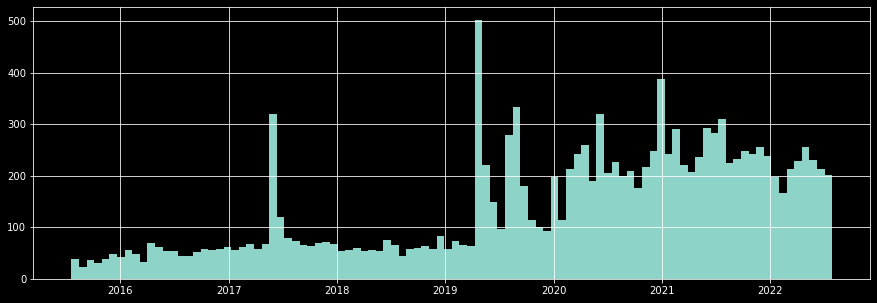

In [10]:
donats['Дата платежа'].hist(figsize = (15, 5), bins=100)

<AxesSubplot:>

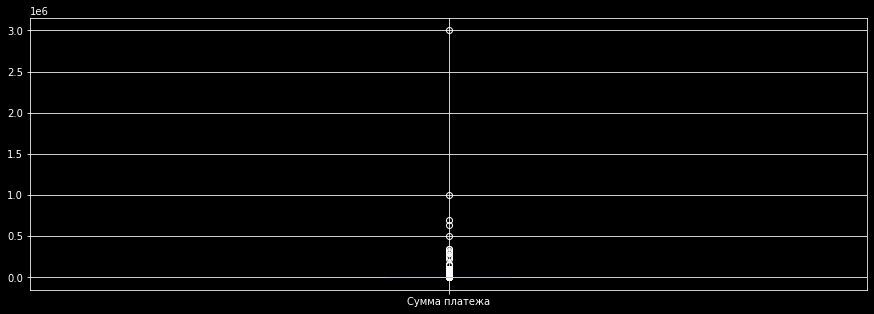

In [11]:
donats.boxplot(column=['Сумма платежа'], figsize = (15, 5))

In [12]:
donats['Сумма платежа'].describe().round()

count      14043.0
mean        1721.0
std        29500.0
min            0.0
25%          150.0
50%          350.0
75%          700.0
max      3000000.0
Name: Сумма платежа, dtype: float64

In [13]:
donats['Рекуррентный'].value_counts(dropna=True).to_frame()

,Рекуррентный
Да,8085
Нет,5958


In [14]:
donats['Назначение платежа'].value_counts(dropna=True).to_frame().head(70)

,Назначение платежа
ПОЖЕРТВОВАНИЕ,3811
"Пожертвование в фонд помощи детям-отказникам и детям-сиротам ""Бюро Добрых Дел""",3335
ПОЖЕРТВОВАНИЕ undefined,2162
Добровольное пожертвование. НДС не облагается,497
SMS bdd,253
...,...
На обучение Дарьи,12
Фотомастерская для Февронии,11
На программу Окно в мир,11
День рождения со смыслом,11


- Donor ID - уникальный идентификатор клиента             
- Дата платежа - начальная дата транзакции       
- Сумма платежа - сумма пожервования         
- Рекуррентный - является ли жервователь рекуррентным         
- Назначение платежа - цель пожервования      
- Канал оплаты - способ оплаты
 
Вывод
- датасет Donor содержит 6 столбцов и 14043 строк
- есть пропущенные значений в столбце 'Назначение платежа' 


# 2. Предобработка данных

In [15]:
# сравним количество уникальных id в обеих датасетах
display(len(donors['ID'].unique()))
len(donats['Donor ID'].unique())

3683

3683

In [16]:
#проверим на дубликаты
'Количество дубликатов:', donors.duplicated().sum()



('Количество дубликатов:', 0)

In [17]:
#проверим на дубликаты
'Количество дубликатов:', donats.duplicated().sum()

('Количество дубликатов:', 12)

In [18]:
donats[donats.duplicated() == True]

,Donor ID,Дата платежа,Сумма платежа,Рекуррентный,Назначение платежа,Канал оплаты
133,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет
297,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет
1438,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет
2837,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет
5166,FFCCBA23-89CA-4A22-BD8A-7CAD2D9EB7F7,2021-09-13,20.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
7654,FFCCBA23-89CA-4A22-BD8A-7CAD2D9EB7F7,2021-09-13,20.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
9594,D38F6A22-9BEF-4484-B377-ED8ED1DB4553,2021-02-11,1.0,Нет ...,ДОБРОВОЛЬНОЕ ПОЖЕРТВОВАНИЕ;Сумма 1.00 руб.;Ком...,Прямые поступления на счет
10112,FFCCBA23-89CA-4A22-BD8A-7CAD2D9EB7F7,2021-09-13,20.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
10685,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет
11757,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет


In [19]:
#eдаляем дубликаты и проверяем
donats = donats.drop_duplicates()
donats.duplicated().sum()

0

In [20]:
# т.к. количество уникальных id равны, объединим таблицы в одну,
# предварительно переименовав столбец в donats

donats = donats.rename(columns={'Donor ID' : 'ID'})

df = donats.merge(donors, how='left', on = 'ID')
df.head(2)

,ID,Дата платежа,Сумма платежа,Рекуррентный,Назначение платежа,Канал оплаты,Пол,Город,Дата последней email активности
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты,Женский ...,Москва,2022-06-03 20:15:57
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,Нет ...,SMS bdd,SMS,Женский ...,Москва,2022-07-18 17:19:02


In [21]:
# переименуем столбцы, приведя их к змеиному (snake case) регистру
df = df.rename(columns = 
              {
                  'ID':'id',
                  'Дата платежа':'date',
                  'Сумма платежа':'amount',
                  'Пол':'gender',
                  'Город':'city',
                  'Назначение платежа' : 'purpose',
                  'Рекуррентный' : 'is_reccurent',
                  'Канал оплаты' : 'channel',
                  'Дата последней email активности': 'last_email_activity'
                  
              }
              )
df.columns

Index(['id', 'date', 'amount', 'is_reccurent', 'purpose', 'channel', 'gender',
       'city', 'last_email_activity'],
      dtype='object')

In [22]:
# посмотрим процентное соотношение пропусков
df.isna().mean()

id                     0.000000
date                   0.000000
amount                 0.000000
is_reccurent           0.000000
purpose                0.090443
channel                0.000000
gender                 0.111824
city                   0.519849
last_email_activity    0.210819
dtype: float64

In [23]:
#заполним пропуски в категориальных признаков no_info 
for column in ['gender', 'purpose']:            
    df[column].fillna('no_info', inplace=True)

In [24]:
# напишем функцию для категоризации городов

def city_category(city):
    foreign_cities = ['Frankfurt am Main', 'Charleston', 'Helsinki', 'Juba', 'Copenhagen', 'Holon', 
                     'Hyderabad', 'Alameda', 'Jakarta', 'Keighley', 'Southall', 'Denver']
    
    if city.loc['city'] == 'Москва':
        return 'Москва'
    elif city.loc['city'] == 'Санкт-Петербург':
        return 'Санкт-Петербург'
    elif city.loc['city'] in foreign_cities:
        return 'Зарубежные страны'
    elif city.loc['city'] == 0:
        return 'Город неизвестен'
    else:
        return 'Другие города России'

df['city'] = df['city'].fillna(0)
# применим функцию
df['city'] = df.apply(city_category, axis=1)
df.head(2)

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты,Женский ...,Москва,2022-06-03 20:15:57
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,Нет ...,SMS bdd,SMS,Женский ...,Москва,2022-07-18 17:19:02


In [25]:
#приведем датасет к нижнему регистру
df = df.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)

In [26]:

# в столбце 'is_reccurent' содержатся значения со множеством пробелов
# заменим их на более удобные 
df['is_reccurent'] = df['is_reccurent'].replace('да                                                                                                                                                                                                                                                        ',
                                                 1)
df['is_reccurent'] = df['is_reccurent'].replace('нет                                                                                                                                                                                                                                                       ',
                                                  0)

In [27]:
# заполним пропуски в столбце 'purpose' и 'last_email_activity'
df['purpose'].fillna('no_info', inplace=True)
df['last_email_activity'].fillna(0, inplace=True)

In [28]:
# заменим в столбце  'last_email_activity' получили email на 1, не получили - 0
df['last_email_activity'] = 1
df.loc[df["last_email_activity"]==0, 'last_email_activity'] = 0

In [29]:
# напишем функцию для категоризации назначения платежа
def purose_category(purpose):
    
    if 'на обучение' in purpose.loc['purpose']:
        return 'обучение'
    elif 'sms' in purpose.loc['purpose']:
        return 'sms'
    elif 'пожертвование' in purpose.loc['purpose']:
        return 'пожертвование'
    else:
        return 'на другие цели'


# применим функцию
df['purpose'] = df.apply(purose_category, axis=1)
df.head()

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity
0,de5393f9-9585-4057-b7fb-24b69697fc08,2022-07-03 19:49:48,300.0,1,пожертвование,банковские карты,женский ...,москва,1
1,81cd4bef-443e-4d36-b34f-664e11182d65,2020-03-14 12:20:02,300.0,0,sms,sms,женский ...,москва,1
2,d3beb76d-d8b6-47e2-8109-44f1b278943b,2022-04-07 00:00:00,16.0,0,пожертвование,прямые поступления на счет,мужской ...,город неизвестен,1
3,f1310736-b229-4aac-99b7-f13acecf67cb,2019-12-26 02:25:42,300.0,0,на другие цели,sms,no_info,город неизвестен,1
4,61c3d86b-39da-445c-9d7f-9924ce9bda14,2021-06-26 01:26:07,200.0,1,пожертвование,банковские карты,женский ...,город неизвестен,1


In [30]:
# проверим пропуски
df.isna().mean()

id                     0.0
date                   0.0
amount                 0.0
is_reccurent           0.0
purpose                0.0
channel                0.0
gender                 0.0
city                   0.0
last_email_activity    0.0
dtype: float64

In [31]:
# выберем период  с 2016-01-01 по 2022-07-01 (2015 год не полный и последный месяц не полный)
df = df[df['date'].between('2016-01-01 00:00:00', '2022-07-01 00:00:00')].copy()

In [32]:
#df[df['id']=='00adba34-1edc-4652-a559-1c0be379a0da'].sort_values(['date'], ascending=[True])

In [33]:

#df = df[df['amount']<=50000].copy()

In [34]:
# сформируем отдельный датасет с информацией о каждом жертвователе, 

df_new = df.groupby('id').agg(
    {'date': ['min', 'max'], 
     'amount':['count', 'sum','mean','median'],
     'last_email_activity':'max',
     'is_reccurent':'max',
     'gender':lambda x: stats.mode(x)[0],
     'city':lambda x: stats.mode(x)[0],
     'channel':lambda x: stats.mode(x)[0],
     'purpose':lambda x: stats.mode(x)[0]
     
    }).set_axis(
    ['first_date', 'last_date',
     'donations_count','donations_sum', 'donations_mean', 'donations_median',
     'last_email_activity',
     'is_reccurent',
     'gender',
     'city',
     'channel',
     'purpose'
    ], 
     axis=1, inplace=False).reset_index()

In [35]:
 # добавляем столбец lifetime: каждого жертвователя в месяцах, иначе 'продолжительность жизни жертвователя' изменив тип данных  

df_new['lifetime'] = ((df_new['last_date'] - df_new['first_date'])/np.timedelta64(1,'D')/30)
df_new['lifetime'] = df_new['lifetime'].apply(np.floor)
df_new['lifetime'] = df_new['lifetime'].replace(0,1)
df_new['lifetime'] = df_new['lifetime'].astype(int)
#df_id['date_day'] = df_id['first_date'].dt.day
#df_id['date_month'] = df_id['first_date'].dt.month
#df_id['date_year'] = df_id['first_date'].dt.year
df_new

,id,first_date,last_date,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,gender,city,channel,purpose,lifetime
0,0001afdd-94e3-48f3-b5e7-d5539700425e,2019-04-26 19:19:24,2019-04-26 19:19:24,1,100.0,100.0,100.0,1,0,no_info,город неизвестен,sms,на другие цели,1
1,000711b2-2785-461b-bf5b-5cb7d2caba20,2020-03-27 08:23:58,2022-06-27 08:24:05,21,10500.0,500.0,500.0,1,1,женский ...,город неизвестен,банковские карты,пожертвование,27
2,0015a100-2d8c-4262-a9b3-bb1461c0c8b8,2021-07-27 12:15:05,2021-07-27 12:17:06,2,400.0,200.0,200.0,1,0,женский ...,москва,банковские карты,на другие цели,1
3,002cb994-10cd-45e9-b6ed-ed7f3c90d7a9,2017-04-27 08:26:17,2017-04-27 08:26:17,1,1000.0,1000.0,1000.0,1,0,женский ...,город неизвестен,банковские карты,пожертвование,1
4,006f71d7-dfcf-4e7a-b9ad-b4721bef4f7a,2019-04-27 00:02:19,2019-04-27 00:02:19,1,200.0,200.0,200.0,1,0,no_info,город неизвестен,sms,на другие цели,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3624,ff946fd1-eef8-4541-a906-bae64527aaa5,2019-05-01 20:27:40,2019-05-01 20:27:40,1,50.0,50.0,50.0,1,0,no_info,город неизвестен,sms,на другие цели,1
3625,ffa30123-a516-44a7-b030-f83ed369b645,2020-03-27 19:55:41,2022-06-03 13:31:14,26,3900.0,150.0,150.0,1,1,женский ...,другие города россии,банковские карты,пожертвование,26
3626,ffb1c4fa-f950-4bb7-a1f2-9dd655298fff,2019-04-26 20:37:02,2019-04-26 20:37:02,1,100.0,100.0,100.0,1,0,no_info,город неизвестен,sms,на другие цели,1
3627,ffccba23-89ca-4a22-bd8a-7cad2d9eb7f7,2021-08-29 00:00:00,2021-09-19 00:00:00,3,60.0,20.0,20.0,1,0,женский ...,город неизвестен,прямые поступления на счет,пожертвование,1


In [36]:
# добавим столбец 'churn'   
df_new['churn']=0

df_new.loc[((df_new['donations_count']/df_new['lifetime']>=1)) 
          & ((df_new['lifetime']>=11)) 
          & ((df_new['is_reccurent']==1)), 'churn'] = 1

df_new

,id,first_date,last_date,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,gender,city,channel,purpose,lifetime,churn
0,0001afdd-94e3-48f3-b5e7-d5539700425e,2019-04-26 19:19:24,2019-04-26 19:19:24,1,100.0,100.0,100.0,1,0,no_info,город неизвестен,sms,на другие цели,1,0
1,000711b2-2785-461b-bf5b-5cb7d2caba20,2020-03-27 08:23:58,2022-06-27 08:24:05,21,10500.0,500.0,500.0,1,1,женский ...,город неизвестен,банковские карты,пожертвование,27,0
2,0015a100-2d8c-4262-a9b3-bb1461c0c8b8,2021-07-27 12:15:05,2021-07-27 12:17:06,2,400.0,200.0,200.0,1,0,женский ...,москва,банковские карты,на другие цели,1,0
3,002cb994-10cd-45e9-b6ed-ed7f3c90d7a9,2017-04-27 08:26:17,2017-04-27 08:26:17,1,1000.0,1000.0,1000.0,1,0,женский ...,город неизвестен,банковские карты,пожертвование,1,0
4,006f71d7-dfcf-4e7a-b9ad-b4721bef4f7a,2019-04-27 00:02:19,2019-04-27 00:02:19,1,200.0,200.0,200.0,1,0,no_info,город неизвестен,sms,на другие цели,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3624,ff946fd1-eef8-4541-a906-bae64527aaa5,2019-05-01 20:27:40,2019-05-01 20:27:40,1,50.0,50.0,50.0,1,0,no_info,город неизвестен,sms,на другие цели,1,0
3625,ffa30123-a516-44a7-b030-f83ed369b645,2020-03-27 19:55:41,2022-06-03 13:31:14,26,3900.0,150.0,150.0,1,1,женский ...,другие города россии,банковские карты,пожертвование,26,1
3626,ffb1c4fa-f950-4bb7-a1f2-9dd655298fff,2019-04-26 20:37:02,2019-04-26 20:37:02,1,100.0,100.0,100.0,1,0,no_info,город неизвестен,sms,на другие цели,1,0
3627,ffccba23-89ca-4a22-bd8a-7cad2d9eb7f7,2021-08-29 00:00:00,2021-09-19 00:00:00,3,60.0,20.0,20.0,1,0,женский ...,город неизвестен,прямые поступления на счет,пожертвование,1,0


In [37]:
df_new.describe().round()

,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,churn
count,3629.0,3629.0,3629.0,3629.0,3629.0,3629.0,3629.0,3629.0
mean,4.0,6505.0,2989.0,2896.0,1.0,0.0,5.0,0.0
std,8.0,67629.0,53906.0,53873.0,0.0,0.0,10.0,0.0
min,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
25%,1.0,150.0,100.0,100.0,1.0,0.0,1.0,0.0
50%,1.0,500.0,300.0,300.0,1.0,0.0,1.0,0.0
75%,2.0,1500.0,543.0,500.0,1.0,0.0,1.0,0.0
max,80.0,3000000.0,3000000.0,3000000.0,1.0,1.0,77.0,1.0


In [38]:
df_new['churn'].value_counts(normalize=True)

0    0.944337
1    0.055663
Name: churn, dtype: float64

# №3. Исследовательский анализ данных

- корреляция Пирсона: 
- посмотрим линейнную зависимомость между признаками

In [39]:
df_new.columns

Index(['id', 'first_date', 'last_date', 'donations_count', 'donations_sum',
       'donations_mean', 'donations_median', 'last_email_activity',
       'is_reccurent', 'gender', 'city', 'channel', 'purpose', 'lifetime',
       'churn'],
      dtype='object')

In [40]:
# посмотрим значения числовых признаков 
df_new[[ 'donations_count', 'donations_sum','lifetime','is_reccurent',
       'donations_mean', 'donations_median', 'last_email_activity']].describe()
        
       

,donations_count,donations_sum,lifetime,is_reccurent,donations_mean,donations_median,last_email_activity
count,3629.000000,3.629000e+03,3629.000000,3629.000000,3.629000e+03,3.629000e+03,3629.0
mean,3.742353,6.505469e+03,4.870488,0.128686,2.988901e+03,2.895992e+03,1.0
std,7.656167,6.762946e+04,10.052770,0.334898,5.390588e+04,5.387319e+04,0.0
min,1.000000,1.000000e-02,1.000000,0.000000,1.000000e-02,1.000000e-02,1.0
25%,1.000000,1.500000e+02,1.000000,0.000000,1.000000e+02,1.000000e+02,1.0
50%,1.000000,5.000000e+02,1.000000,0.000000,3.000000e+02,3.000000e+02,1.0
75%,2.000000,1.500000e+03,1.000000,0.000000,5.428571e+02,5.000000e+02,1.0
max,80.000000,3.000000e+06,77.000000,1.000000,3.000000e+06,3.000000e+06,1.0


Количественные признаки у жертвователя


,donations_count,donations_sum,lifetime,is_reccurent,donations_mean,donations_median
donations_count,1.000000,0.136979,0.803573,0.702870,-0.011343,-0.013614
donations_sum,0.136979,1.000000,0.151157,0.074391,0.813103,0.800320
lifetime,0.803573,0.151157,1.000000,0.580839,-0.008053,-0.012902
is_reccurent,0.702870,0.074391,0.580839,1.000000,-0.013473,-0.014942
donations_mean,-0.011343,0.813103,-0.008053,-0.013473,1.000000,0.999347
donations_median,-0.013614,0.800320,-0.012902,-0.014942,0.999347,1.000000


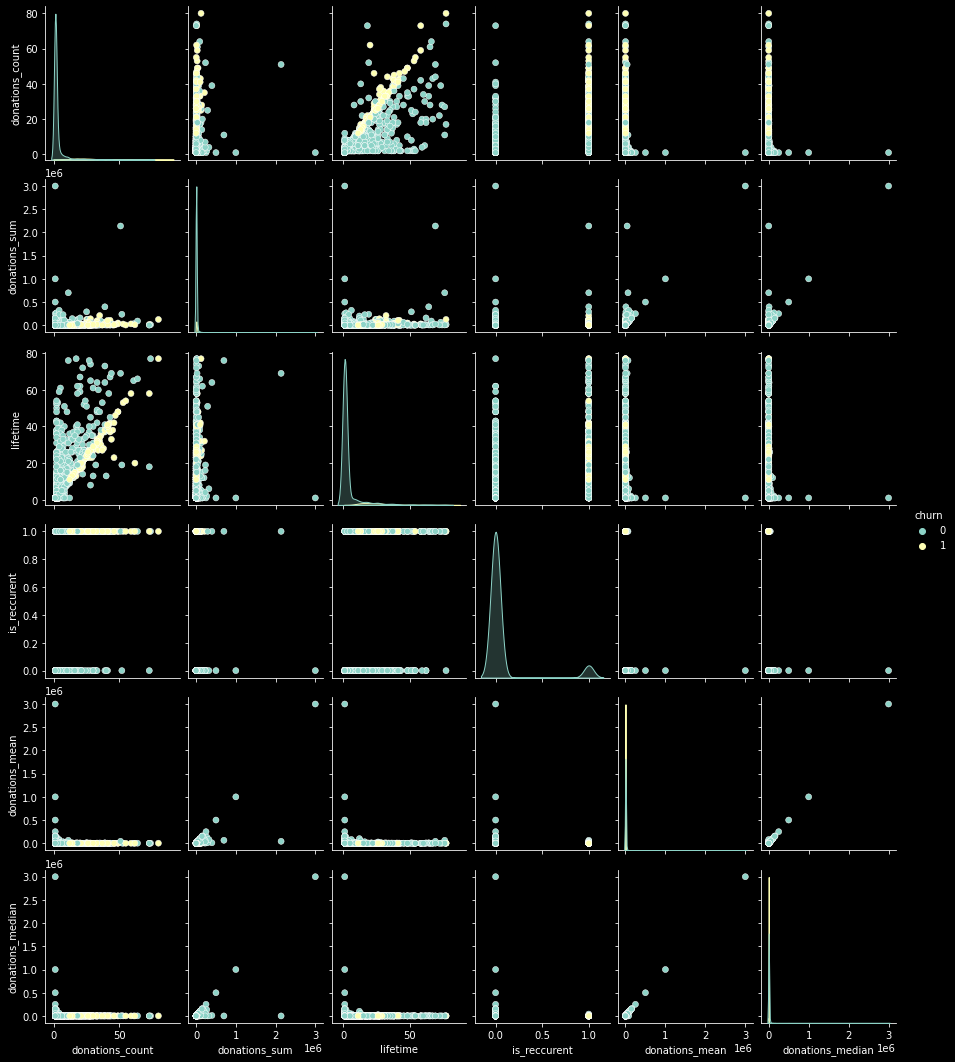

In [41]:
# Посмотрим на количественные признаки
print('Количественные признаки у жертвователя')
sns.pairplot(df_new[[ 'donations_count', 'donations_sum','lifetime','is_reccurent',
       'donations_mean', 'donations_median', 'churn']], aspect=.85, hue='churn')#, aspect=.85, hue='churn')
df_new[[ 'donations_count', 'donations_sum','lifetime','is_reccurent',
       'donations_mean', 'donations_median']].corr().style.background_gradient()

- корреляция Пирсона больше 0.80 между:
-  'lifetime', 'is_reccurent' и 'donations_count' 
- сильная связь есть между 'lifetime', 'is_reccurent', корреляция Пирсона 0.58


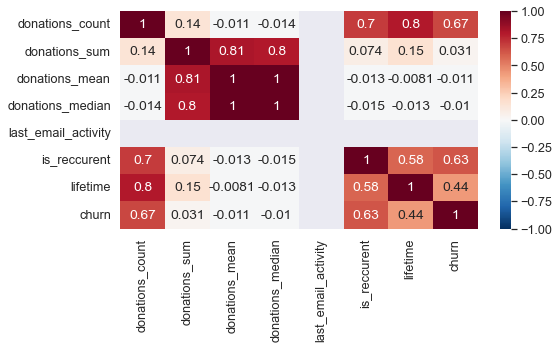

In [42]:
sns.set(font_scale=1.15)
plt.figure(figsize=(8,4))
sns.heatmap(
    df_new.corr(),        
    cmap='RdBu_r', 
    annot=True, 
    vmin=-1, vmax=1); 

In [43]:
#df_new.query('is_reccurent==1')

- Корреляция Фика: 
- посмотрим нелинейнную зависимомость между признаками

In [44]:
#корреляция Фика (нелинейнная зависимомость между признаками)
phik_overview = df_new.phik_matrix()

interval columns not set, guessing: ['donations_count', 'donations_sum', 'donations_mean', 'donations_median', 'last_email_activity', 'is_reccurent', 'lifetime', 'churn']


The number of unique values of variable first_date is large: 3468. Are you sure this is not an interval variable? Analysis for pairs of variables including first_date can be slow.
The number of unique values of variable id is large: 3629. Are you sure this is not an interval variable? Analysis for pairs of variables including id can be slow.
The number of unique values of variable last_date is large: 3463. Are you sure this is not an interval variable? Analysis for pairs of variables including last_date can be slow.
Not enough unique value for variable last_email_activity for analysis 1. Dropping this column
/opt/anaconda3/lib/python3.9/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 12009684. Are interval variables set correctly?
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 12585372. Are interval variables set correctly?
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/phik/bivariate.py:241: UserWa

In [45]:
#важность признаков в датасете 
phik_overview['churn'].sort_values(ascending=False)

id                  1.000000
first_date          1.000000
last_date           1.000000
churn               1.000000
is_reccurent        0.835650
lifetime            0.746153
donations_count     0.708904
purpose             0.357259
channel             0.138251
city                0.104229
gender              0.103346
donations_sum       0.000000
donations_mean      0.000000
donations_median    0.000000
Name: churn, dtype: float64

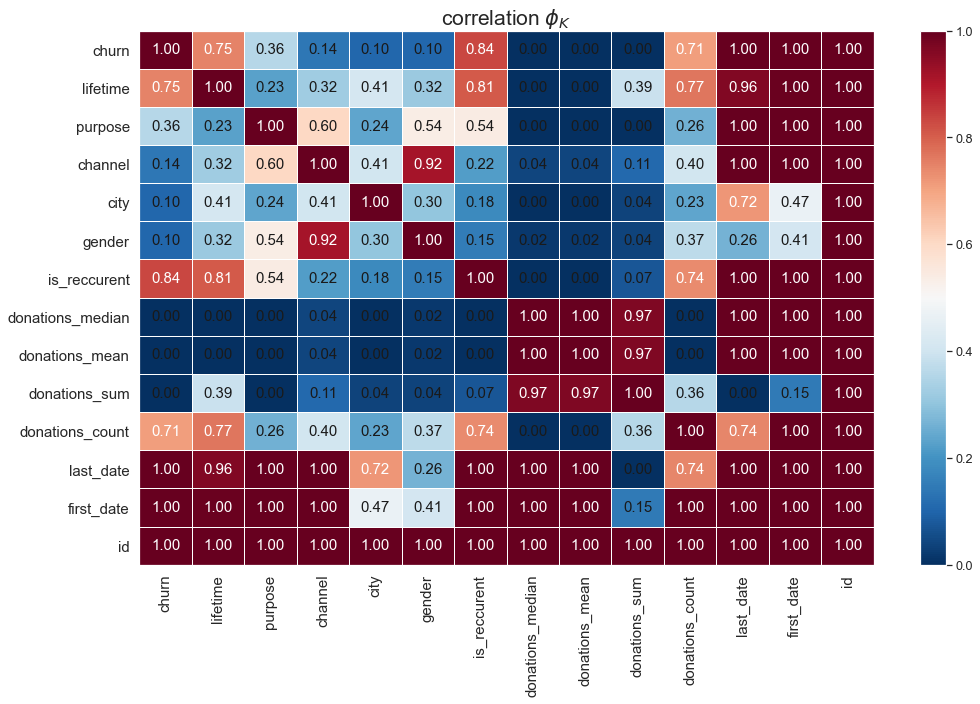

In [46]:

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='RdBu_r', 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 10))
plt.tight_layout()

На целевой признак больше всего влияют: 
- is_reccurent:        0.835650
- lifetime:            0.746153
- donations_count:     0.708904
- purpose:             0.357259


#  Модель CatBoostClassifier

In [47]:

#разбиваем на 2 части: обучающую (70) и тестовую (30)
train, test = train_test_split(df_new, train_size=0.70, random_state=42, stratify = df_new['churn']) #df_new[df_new['last_date'].between('2021-07-01 00:00:00', '2022-06-01 00:00:00')]#
#test = df_new[df_new['last_date'].between('2022-06-01 00:00:00', '2022-07-01 00:00:00')]
print(f"Среднее в обучающей выборке: {train['churn'].mean()}")
print(f"Среднее в тестовой выборке: {test['churn'].mean()}")
print(f"Количество записей в обучающей выборке: {train.shape}")
print(f"Количество записей в тестовой выборке: {test.shape}")

Среднее в обучающей выборке: 0.05551181102362205
Среднее в тестовой выборке: 0.05601469237832874
Кол-во записей в обучающей выборке: (2540, 15)
Кол-во записей в тестовой выборке: (1089, 15)


In [48]:
# удаляем лишние столбцы(информация есть в столбце lifetime) 
#df_new = df_new.drop([ 'first_date', 'last_date', 'id', 'donations_mean'], axis=1)

In [49]:
train.columns

Index(['id', 'first_date', 'last_date', 'donations_count', 'donations_sum',
       'donations_mean', 'donations_median', 'last_email_activity',
       'is_reccurent', 'gender', 'city', 'channel', 'purpose', 'lifetime',
       'churn'],
      dtype='object')

In [50]:
# список призноков
X = [ 'donations_count', 'donations_sum','city', 'donations_median',
       'channel','is_reccurent', 'lifetime', 'gender', 'purpose','last_email_activity' ]
    
      
# список целевого признака

y=['churn']

#список категориальных признаков
cat_features =['gender', 'city', 'purpose', 'channel']

In [51]:
params = {'cat_features': cat_features,
          'eval_metric': 'AUC',
          'loss_function': 'Logloss',
          'learning_rate': 0.01,
          'depth': 2,
          'random_seed': 42,
          'verbose':10,
          'iterations': 500}

In [52]:

train_data = Pool(data=train[X],
                  label=train[y],
                 cat_features=cat_features
                 )

In [53]:
cv_data = cv(
    params = params,
    pool = train_data,
    verbose=False,
    fold_count=5,
    plot="True",
    shuffle=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.9980603448
bestIteration = 481

Training on fold [1/5]

bestTest = 0.9979166667
bestIteration = 440

Training on fold [2/5]

bestTest = 0.997172619
bestIteration = 493

Training on fold [3/5]

bestTest = 0.9940848214
bestIteration = 186

Training on fold [4/5]

bestTest = 0.9959737548
bestIteration = 411



In [54]:
cv_data

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.966116,0.017019,0.661835,0.005727,0.661875,0.005778
1,1,0.983742,0.007172,0.632012,0.005117,0.632018,0.005354
2,2,0.987499,0.004580,0.600855,0.005124,0.600901,0.005489
3,3,0.987959,0.005835,0.572227,0.005156,0.572101,0.005425
4,4,0.987500,0.004784,0.549273,0.004741,0.549114,0.004925
...,...,...,...,...,...,...,...
495,495,0.996457,0.001777,0.037120,0.004684,0.031149,0.001833
496,496,0.996457,0.001777,0.037101,0.004677,0.031116,0.001833
497,497,0.996457,0.001777,0.037086,0.004720,0.031080,0.001791
498,498,0.996457,0.001777,0.037085,0.004738,0.031066,0.001783


In [55]:
cv_data[cv_data['test-AUC-mean'] == cv_data['test-AUC-mean'].max()]

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
474,474,0.996457,0.001712,0.037447,0.004699,0.031656,0.001766
475,475,0.996457,0.001712,0.037444,0.004712,0.031640,0.001765


In [56]:
params = {'cat_features': cat_features,
          'eval_metric': 'AUC',
          'loss_function': 'Logloss',
          'learning_rate': 0.01,
          'random_seed': 42,
          'verbose':10,
          'iterations': 498,
          }

In [57]:
model = CatBoostClassifier(**params)

In [58]:
plt.style.use('dark_background')
model.fit(train_data, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	total: 4.59ms	remaining: 2.28s
10:	total: 61.8ms	remaining: 2.73s
20:	total: 89.2ms	remaining: 2.03s
30:	total: 114ms	remaining: 1.72s
40:	total: 146ms	remaining: 1.62s
50:	total: 176ms	remaining: 1.54s
60:	total: 202ms	remaining: 1.44s
70:	total: 230ms	remaining: 1.38s
80:	total: 259ms	remaining: 1.33s
90:	total: 305ms	remaining: 1.36s
100:	total: 332ms	remaining: 1.3s
110:	total: 358ms	remaining: 1.25s
120:	total: 387ms	remaining: 1.2s
130:	total: 416ms	remaining: 1.16s
140:	total: 442ms	remaining: 1.12s
150:	total: 470ms	remaining: 1.08s
160:	total: 496ms	remaining: 1.04s
170:	total: 524ms	remaining: 1s
180:	total: 548ms	remaining: 960ms
190:	total: 574ms	remaining: 923ms
200:	total: 594ms	remaining: 878ms
210:	total: 617ms	remaining: 839ms
220:	total: 638ms	remaining: 800ms
230:	total: 664ms	remaining: 767ms
240:	total: 685ms	remaining: 731ms
250:	total: 705ms	remaining: 694ms
260:	total: 729ms	remaining: 662ms
270:	total: 748ms	remaining: 627ms
280:	total: 773ms	remaining: 597m

# Тестирование модели

In [59]:
predict_cat = model.predict_proba(test[X])[:, 1]
roc_auc_cat = roc_auc_score(test[y], predict_cat)
accuracy_cat = model.score(test[X], test[y])
print(f"Accuracy на тестовой выборке : {accuracy_cat:.5f}")
print(f"ROC_AUC для модели CatBoost на тестовой выборке: {roc_auc_cat:.5f}")

Accuracy на тестовой выборке : 0.98898
ROC_AUC для модели CatBoost на тестовой выборке: 0.99764


Модель | ROC_AUC на валидационной выборке | ROC_AUC на тестовой выборке | Accuracy на тестовой выборке
--- | --- | --- | ---
*CatBoostClassifier* | **0.99644** | **0.99764** | **0.98898**

[Text(0.5, 0, 'Predicted'),
 Text(0, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Confusion Matrix Actual vs Predicted')]

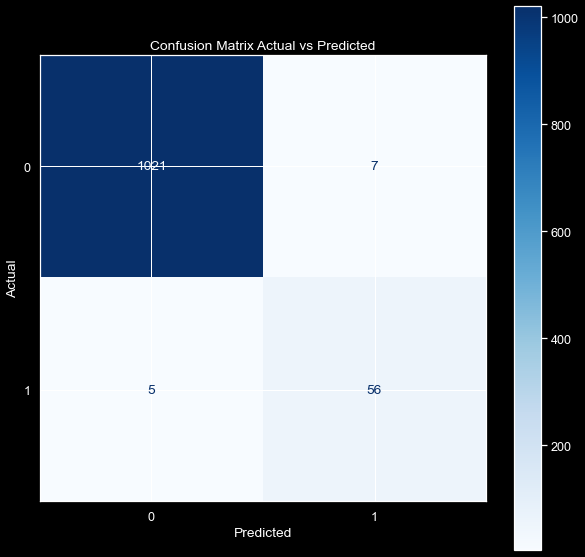

In [74]:
# построим confusion_matrix
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(model, test[X], test[y], ax=ax, cmap=plt.cm.Blues)
ax.set(xlabel='Predicted', ylabel='Actual', title='Confusion Matrix Actual vs Predicted')

- TP — истино-положительное решение: Интерпретация: мы предсказали положительное значения - 56
- TN — истино-отрицательное решение: Интерпретация: мы прогнозировали отрицательное значения - 1021
- FP — ложно-положительное решение (Ошибка типа 1): Интерпретация: мы предсказали положительное значения - 7
- FN— ложно-отрицательное решение (Ошибка Типа 2): Интерпретация: мы предсказали отрицательное значения - 5 



# С помощью Shap можно определить наиболее значимые факторы

In [60]:
#проверим на адекватность модели
#рассчитываем важность признаков с помощью SHAP
model.get_feature_importance(prettified=True)


,Feature Id,Importances
0,is_reccurent,29.806622
1,donations_count,29.722233
2,lifetime,18.012375
3,channel,9.049809
4,purpose,4.749632
5,donations_median,2.699987
6,donations_sum,2.217230
7,gender,2.011952
8,city,1.730158
9,last_email_activity,0.000000


Вывод\
Из таблицы видно, ответственность объекта за изменение выходных данных модели, такие как 
- is_reccurent 
- donations_count
- lifetime
- channel
- purpose\
Наша модель не увидела зависимость от last_email_activity.


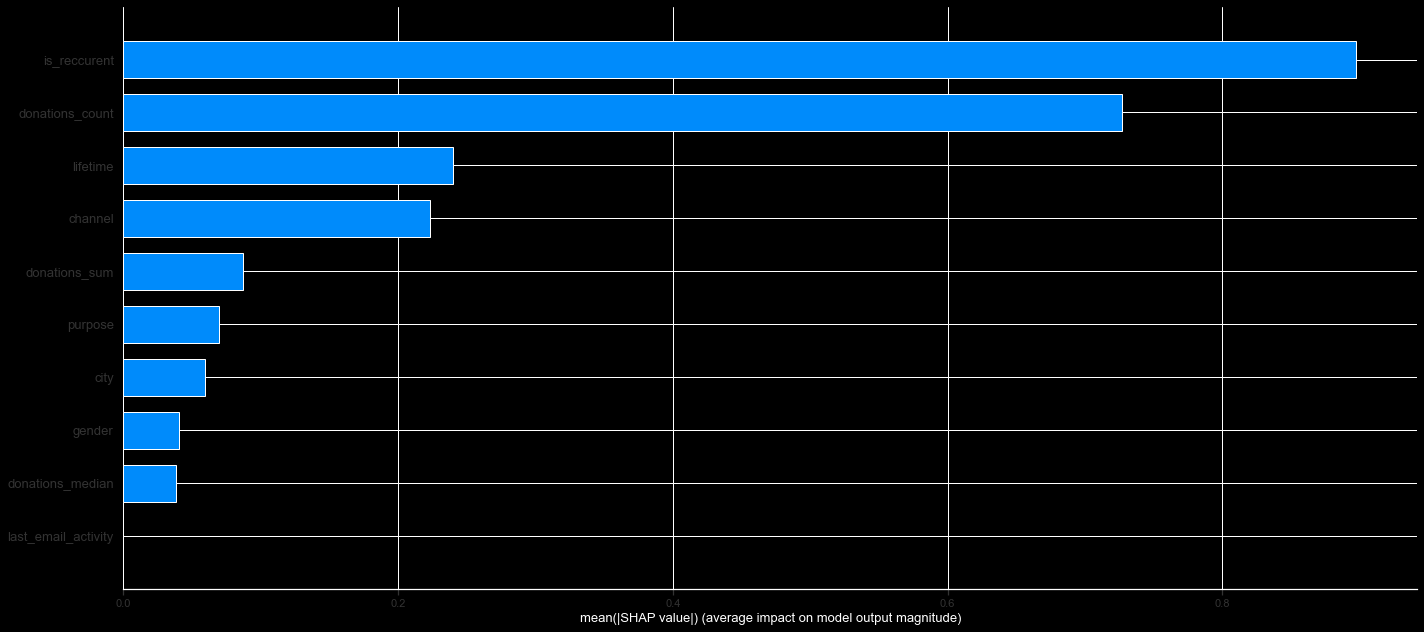

In [61]:
# построим барчарт
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test[X])
shap.summary_plot(shap_values, test[X], plot_type="bar", plot_size=(20,9))

- Чтобы понять, как отдельный объект влияет на выходные данные модели, мы можем построить график зависимости значения этого объекта от значение функции для всех примеров в наборе данных. Поскольку значения SHAP представляют ответственность объекта за изменение выходных данных модели, график ниже представляет изменение изменение целевого признака 

In [62]:
# Рассмотрим SHAP-графики. Построим такой график для каждого наблюдения в датасете
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, test[X])

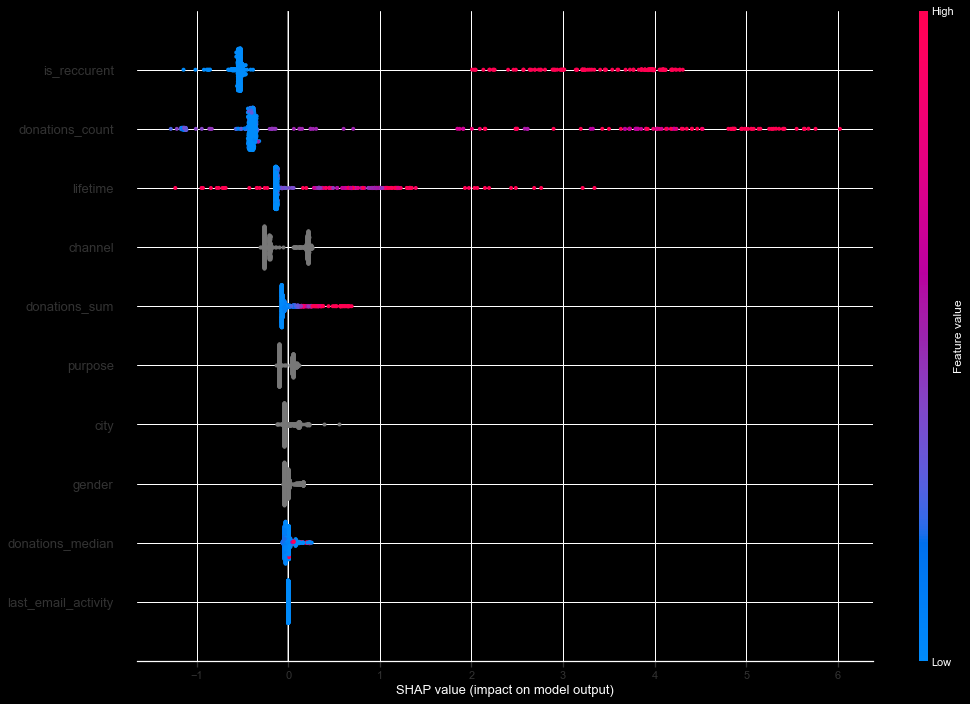

In [63]:
# сортируем объекты по сумме значений SHAP на тестовой выборке 
shap.summary_plot(shap_values, test[X], plot_size=(15,10))

- Приведенный выше график сортирует объекты по сумме значений SHAP на тестовой выборке и использует значения SHAP для отображения распределения влияния каждого объекта на выходные данные модели.

In [64]:
#посмотреть зависимость предсказаний от конкретного признака в виде 2D графика
features = model.get_feature_importance(prettified=True)['Feature Id'].values

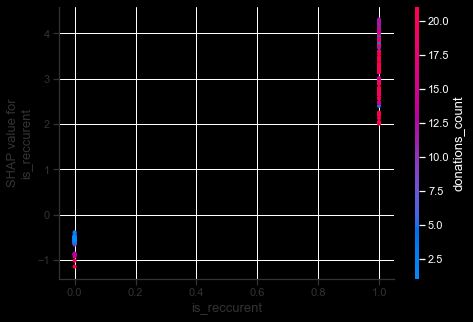

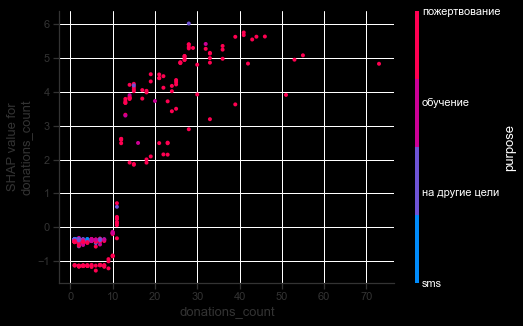

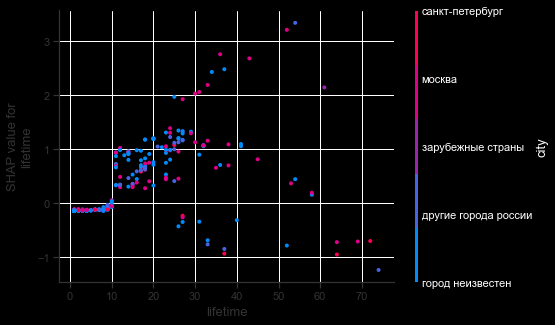

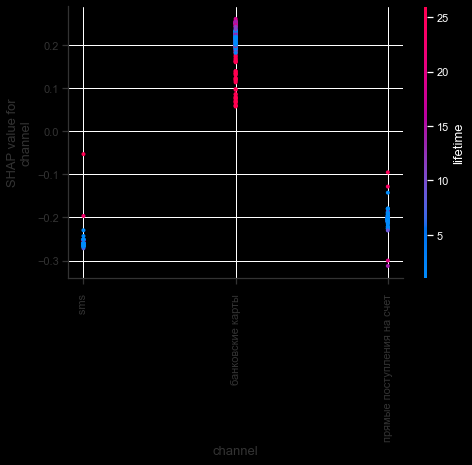

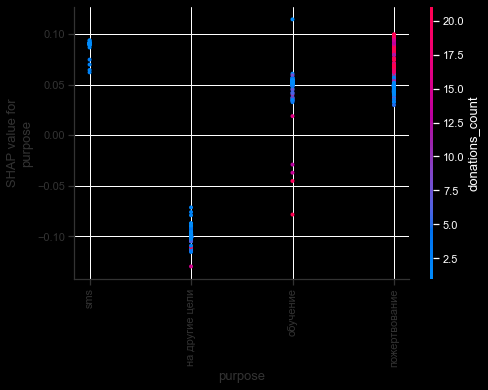

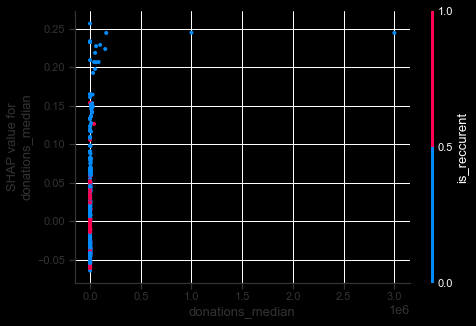

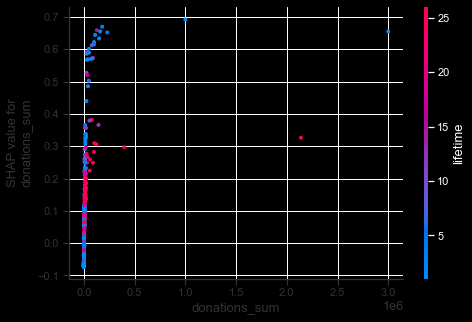

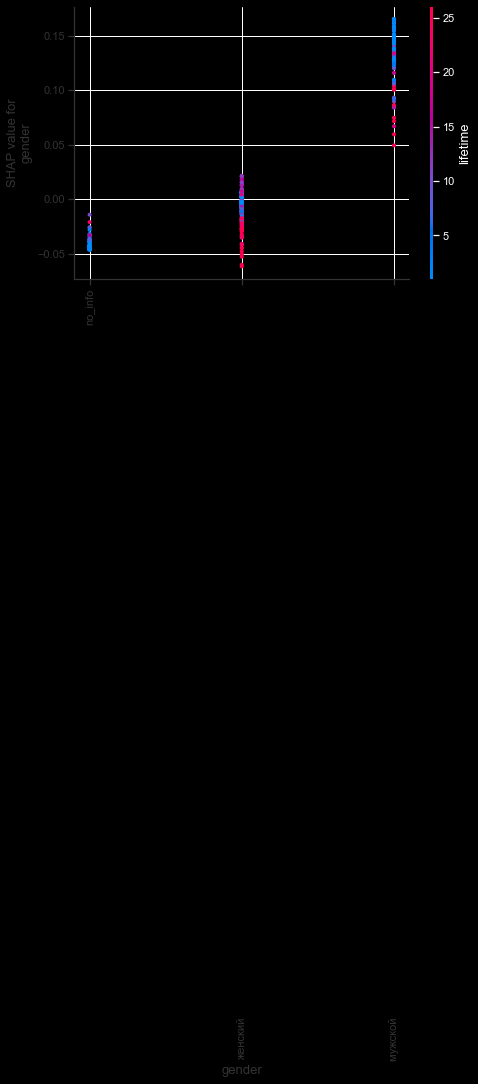

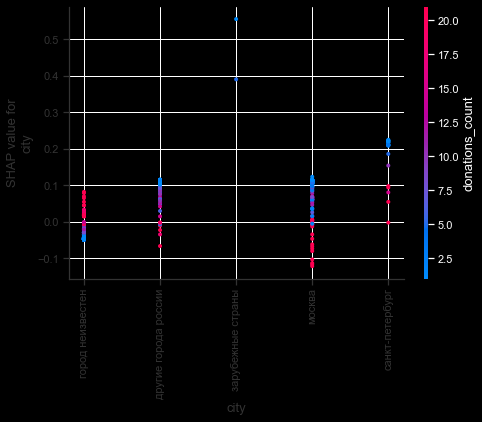

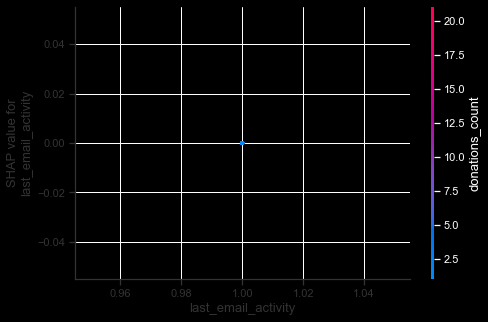

In [70]:
# посмотреть зависимость предсказаний от конкретного признака в виде 2D графика для всех признаков
for features in features:
    shap.dependence_plot(features, shap_values, test[X])

Вывод\
Таким образом, из этого графика можно сделать интересные выводы и проверить их адекватность\
На основании подобных выводов можно сформировать портрет жертвователя.
Полученные графики интерпретируется следующим образом

- рекуррентные жертвователи часто делают взносы
- больше всего жертвуют в фонд 
- короткой lifetime характерная черта жервователя из других городов России
- способ оплаты жертвователя в основном через банковские карты
- крупные и очень маленькие суммы жертвуют с коротким lifetime 



- Рекомендацией может быть - проведение большего числа мероприятий с учетом специфики поведения разовых и многоразовых жертвователей.
- На мой взгляд, модель машинного обучения на основе имеющихся данных не сможет корректно предсказать, так как недостаточно признаков, которые описывают поведение и фин. состояние жертвователей.